In [1]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def load_training():
    images = np.load(os.path.join('../Data_final_calcver', 'X_train.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'train_calc_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_calcver', 'train_calc_FN.npy'))
    return images, labels#, FN


def load_testing():
    images = np.load(os.path.join('../Data_final_calcver', 'X_test.npy'))
    labels = np.load(os.path.join('../Data_final_calcver', 'test_calc_labels2_num.npy'))
    #FN = np.load(os.path.join('../Data_final_calcver', 'test_calc_FN.npy'))
    return images, labels#, FN

In [3]:
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 1535 	 Test size: 337
Image size: 256x256


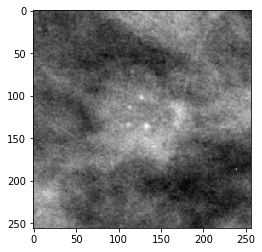

Label: 0


In [4]:
idx = 10

plt.imshow(test_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))
#print("FN: " + str(test_FN[idx]))

In [5]:
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [6]:
train_images.shape

(1535, 256, 256, 1)

In [7]:
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [8]:
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [9]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [10]:
train_datagen.fit(train_images)

train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

preprocess_input(test_images);

In [11]:
def create_vgg19(verbose=False, fc_size=256, output = 4, dropout=None):

    vgg19_base = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg19 = models.Sequential()
    vgg19.add(vgg19_base)

    vgg19.add(layers.Flatten())
    if dropout is not None:
        vgg19.add(layers.Dropout(dropout))
    vgg19.add(layers.Dense(1024, activation='relu'))
    vgg19.add(layers.Dense(fc_size, activation='relu'))
    vgg19.add(layers.Dense(output, activation='softmax'))

    vgg19_base.trainable = False
    
    if verbose:
        vgg19_base.summary()
        vgg19.summary()

    return vgg19

In [12]:
vgg = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
for layer in vgg.layers:
    layer.trainable = False
vgg_maxpool = vgg.get_layer('block5_pool').output
FeatureFlatten = Flatten()(vgg_maxpool)
dense1 = Dense(1024, name = 'dense1', activation = 'relu')(FeatureFlatten)
dense2 = Dense(128, name = 'dense2', activation = 'relu')(dense1)
predictions = Dense(2, name = 'predictions', activation = 'softmax')(dense2)

new_vgg = Model(inputs = vgg.input, outputs = predictions)
new_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
vgg19_calc_benign_or_malignant_best_RMSprop = new_vgg

In [14]:
vgg19_calc_benign_or_malignant_best_Adam = new_vgg

In [15]:
vgg19_calc_benign_or_malignant_best_Adam = create_vgg19(dropout=0.5, fc_size=128, output = 2)

In [16]:
vgg19_calc_benign_or_malignant_best_Adam.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              33555456  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 53,711,298
Trainable params: 33,686,914
Non-trainable params: 20,024,384
___________________________________

### Adam

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_Adam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_Adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [16]:
# Train
history_vgg19_calc_benign_or_malignant_best_Adam = vgg19_calc_benign_or_malignant_best_Adam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 2.6040 - recall: 0.5977
Epoch 00001: val_loss improved from inf to 1.54144, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 15s 3s/step - loss: 2.4047 - recall: 0.5984 - val_loss: 1.5414 - val_recall: 0.5505
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0357 - recall: 0.6348
Epoch 00002: val_loss improved from 1.54144 to 0.78875, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 11s 2s/step - loss: 1.0303 - recall: 0.6344 - val_loss: 0.7888 - val_recall: 0.6743
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6831 - recall: 0.6465
Epoch 00003: val_loss did not improve from 0.78875
5/5 [=============

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5033 - recall: 0.7109
Epoch 00028: val_loss did not improve from 0.53456
5/5 [==============================] - 11s 2s/step - loss: 0.5052 - recall: 0.7109 - val_loss: 0.5747 - val_recall: 0.7427
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5138 - recall: 0.7022
Epoch 00029: val_loss improved from 0.53456 to 0.53416, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adam.h5
5/5 [==============================] - 11s 2s/step - loss: 0.5244 - recall: 0.7092 - val_loss: 0.5342 - val_recall: 0.7231
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5087 - recall: 0.7246
Epoch 00030: val_loss did not improve from 0.53416
5/5 [==============================] - 11s 2s/step - loss: 0.5199 - recall: 0.7281 - val_loss: 0.5913 - val_recall: 0.7036
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5377 - recall: 0.7168
Epoch 00031: val_loss did not improv

5/5 [==============================] - 10s 2s/step - loss: 0.4731 - recall: 0.7313 - val_loss: 0.5070 - val_recall: 0.7557
Epoch 58/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5001 - recall: 0.7188
Epoch 00058: val_loss did not improve from 0.50702
5/5 [==============================] - 11s 2s/step - loss: 0.4943 - recall: 0.7266 - val_loss: 0.5511 - val_recall: 0.7101
Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4933 - recall: 0.7435
Epoch 00059: val_loss did not improve from 0.50702
5/5 [==============================] - 11s 2s/step - loss: 0.5098 - recall: 0.7245 - val_loss: 0.5378 - val_recall: 0.7427
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4663 - recall: 0.7402
Epoch 00060: val_loss did not improve from 0.50702
5/5 [==============================] - 10s 2s/step - loss: 0.4897 - recall: 0.7375 - val_loss: 0.5479 - val_recall: 0.7296
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4845 - re

In [17]:
models.save_model(vgg19_calc_benign_or_malignant_best_Adam, '../model/vgg19_calc_benign_or_malignant_end_Adam.h5')

In [18]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adam.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adam.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adam.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adam.history['val_recall']

In [19]:
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_Adam.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_Adam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

In [20]:
print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 106
Epoch [opt]: 76
Valid recall [end]: 0.7068
Valid recall [opt]: 0.7524
Test recall [end]:  0.7062
Test recall [opt]:  0.7389
Valid loss [end]: 0.5704
Valid loss [opt]: 0.4958
Test loss [end]:  0.5329
Test loss [opt]:  0.5391


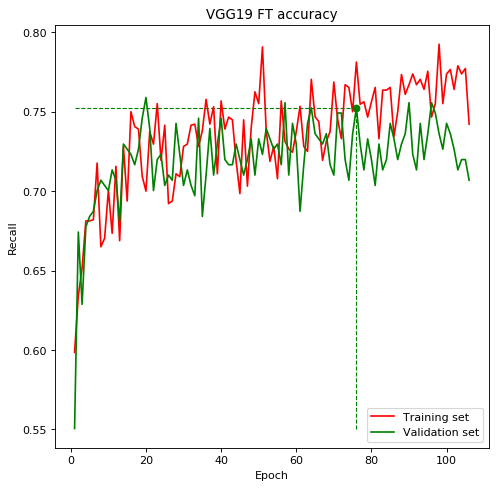

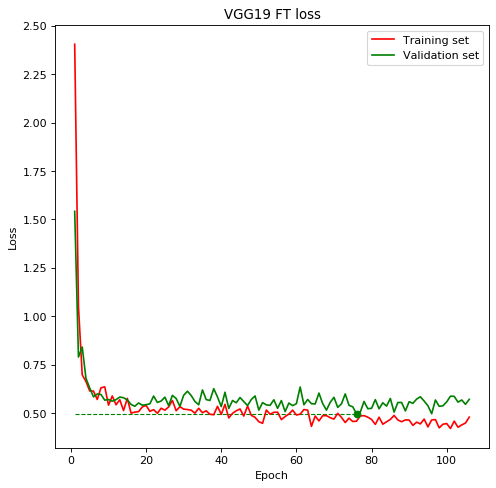

In [21]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### SGD

In [22]:
vgg19_calc_benign_or_malignant_best_SGD = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_SGD.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_SGD.compile(optimizer=optimizers.SGD(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [23]:
# Train
history_vgg19_calc_benign_or_malignant_best_SGD = vgg19_calc_benign_or_malignant_best_SGD.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4488 - recall: 0.4652
Epoch 00001: val_loss improved from inf to 0.99974, saving model to ../model/vgg19_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 10s 2s/step - loss: 1.3982 - recall: 0.4864 - val_loss: 0.9997 - val_recall: 0.5603
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3981 - recall: 0.4935
Epoch 00002: val_loss did not improve from 0.99974
5/5 [==============================] - 11s 2s/step - loss: 1.3551 - recall: 0.5068 - val_loss: 1.0895 - val_recall: 0.5603
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4486 - recall: 0.5234
Epoch 00003: val_loss improved from 0.99974 to 0.92534, saving model to ../model/vgg19_calc_benign_or_malignant_best_SGD.h5
5/5 [==============================] - 11s 2s/step - loss: 1.4600 - recall: 0.5266 - val_loss: 0

Epoch 00058: early stopping


In [24]:
models.save_model(vgg19_calc_benign_or_malignant_best_SGD, '../model/vgg19_calc_benign_or_malignant_end_SGD.h5')

In [25]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_SGD.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_SGD.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_SGD.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_SGD.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_SGD.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_SGD.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 58
Epoch [opt]: 28
Valid recall [end]: 0.6906
Valid recall [opt]: 0.6906
Test recall [end]:  0.6944
Test recall [opt]:  0.6795
Valid loss [end]: 0.6878
Valid loss [opt]: 0.6024
Test loss [end]:  0.6736
Test loss [opt]:  0.7581


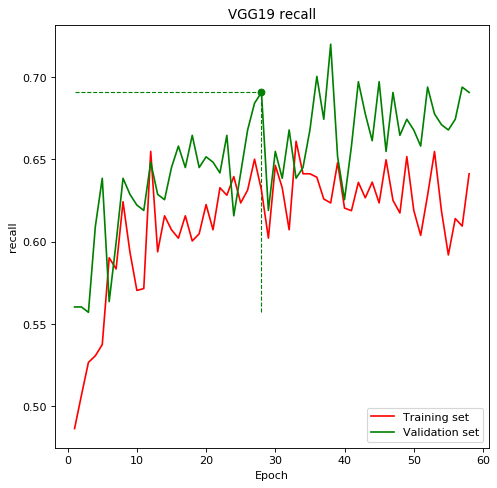

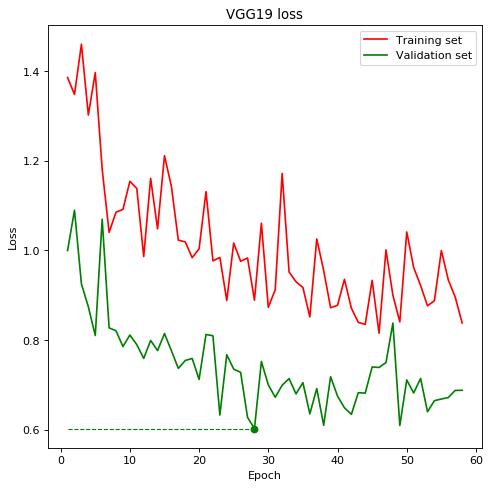

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 recall')
plt.ylabel('recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### RMSprop

In [27]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_RMSprop.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [28]:
# Train
history_vgg19_calc_benign_or_malignant_best_RMSprop = vgg19_calc_benign_or_malignant_best_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6466 - recall: 0.7109
Epoch 00001: val_loss improved from inf to 0.65319, saving model to ../model/vgg19_calc_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6693 - recall: 0.6922 - val_loss: 0.6532 - val_recall: 0.6873
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5565 - recall: 0.6934
Epoch 00002: val_loss improved from 0.65319 to 0.54366, saving model to ../model/vgg19_calc_benign_or_malignant_best_RMSprop.h5
5/5 [==============================] - 12s 2s/step - loss: 0.5378 - recall: 0.7063 - val_loss: 0.5437 - val_recall: 0.7524
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4841 - recall: 0.7383
Epoch 00003: val_loss did not improve from 0.54366
5/5 [==============================] - 11s 2s/step - loss: 0.4749 - recall: 0.7453 - val

In [29]:
models.save_model(vgg19_calc_benign_or_malignant_best_RMSprop, '../model/vgg19_calc_benign_or_malignant_end_RMSprop.h5')

In [30]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_RMSprop.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_RMSprop.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_RMSprop.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_RMSprop.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_RMSprop.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 35
Epoch [opt]: 5
Valid recall [end]: 0.6873
Valid recall [opt]: 0.7362
Test recall [end]:  0.6944
Test recall [opt]:  0.6914
Valid loss [end]: 0.6740
Valid loss [opt]: 0.5324
Test loss [end]:  0.6440
Test loss [opt]:  0.5781


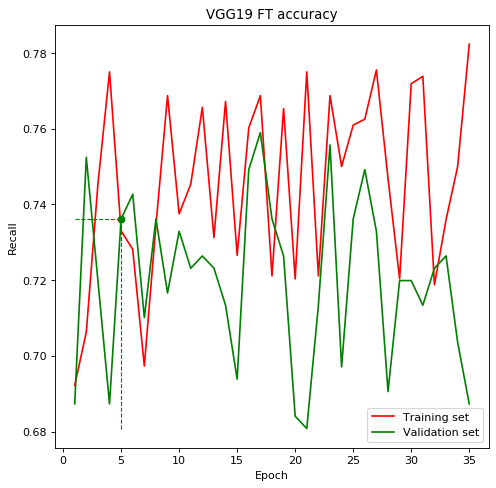

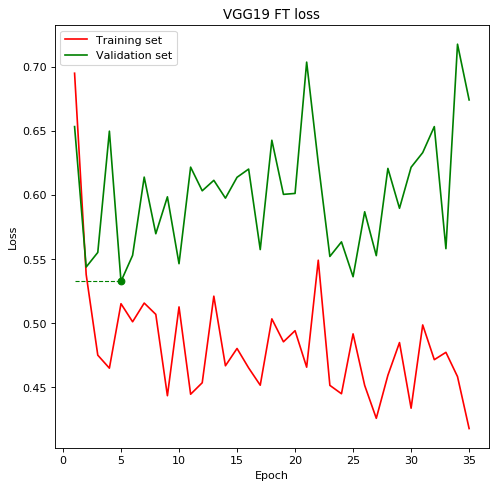

In [31]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adadelta

In [32]:
vgg19_calc_benign_or_malignant_best_Adadelta = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_Adadelta.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_Adadelta.compile(optimizer=optimizers.Adadelta(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [33]:
# Train
history_vgg19_calc_benign_or_malignant_best_Adadelta = vgg19_calc_benign_or_malignant_best_Adadelta.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4490 - recall: 0.5039
Epoch 00001: val_loss improved from inf to 1.01160, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adadelta.h5
5/5 [==============================] - 12s 2s/step - loss: 1.4461 - recall: 0.4891 - val_loss: 1.0116 - val_recall: 0.4593
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4166 - recall: 0.5000
Epoch 00002: val_loss did not improve from 1.01160
5/5 [==============================] - 11s 2s/step - loss: 1.4150 - recall: 0.5094 - val_loss: 1.0794 - val_recall: 0.4691
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4390 - recall: 0.4805
Epoch 00003: val_loss did not improve from 1.01160
5/5 [==============================] - 11s 2s/step - loss: 1.3849 - recall: 0.4875 - val_loss: 1.1557 - val_recall: 0.5016
Epoch 4/300
4/5 [=======================>

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3086 - recall: 0.5273
Epoch 00030: val_loss did not improve from 0.77111
5/5 [==============================] - 10s 2s/step - loss: 1.3545 - recall: 0.5323 - val_loss: 0.8614 - val_recall: 0.5668
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2201 - recall: 0.5978
Epoch 00031: val_loss did not improve from 0.77111
5/5 [==============================] - 10s 2s/step - loss: 1.2309 - recall: 0.5731 - val_loss: 0.8042 - val_recall: 0.6026
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 1.3378 - recall: 0.5273
Epoch 00032: val_loss did not improve from 0.77111
5/5 [==============================] - 10s 2s/step - loss: 1.3240 - recall: 0.5375 - val_loss: 0.9993 - val_recall: 0.6026
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1793 - recall: 0.5566
Epoch 00033: val_loss did not improve from 0.77111
5/5 [==============================] - 11s 2s/step - loss: 

In [34]:
models.save_model(vgg19_calc_benign_or_malignant_best_Adadelta, '../model/vgg19_calc_benign_or_malignant_end_Adadelta.h5')

In [35]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adadelta.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adadelta.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adadelta.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adadelta.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_Adadelta.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_Adadelta.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 42
Epoch [opt]: 12
Valid recall [end]: 0.6091
Valid recall [opt]: 0.5440
Test recall [end]:  0.5816
Test recall [opt]:  0.5371
Valid loss [end]: 0.7943
Valid loss [opt]: 0.7711
Test loss [end]:  1.0713
Test loss [opt]:  1.1862


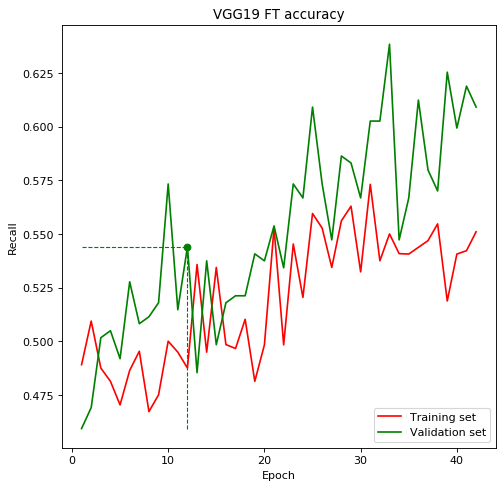

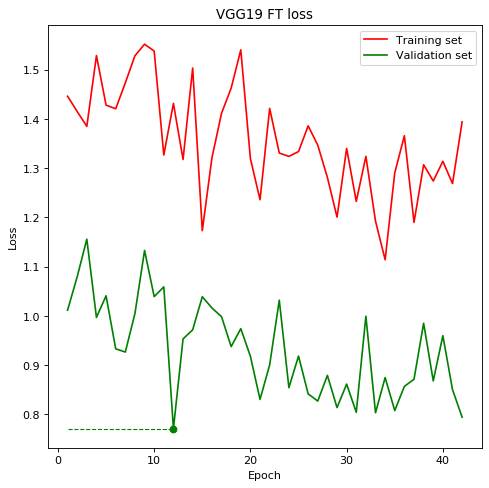

In [36]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adagrad

In [13]:
vgg19_calc_benign_or_malignant_best_Adagrad = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_Adagrad.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_Adagrad.compile(optimizer=optimizers.Adagrad(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_calc_benign_or_malignant_best_Adagrad = vgg19_calc_benign_or_malignant_best_Adagrad.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.7962 - recall: 0.4957
Epoch 00001: val_loss improved from inf to 1.14851, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 18s 4s/step - loss: 1.6666 - recall: 0.5255 - val_loss: 1.1485 - val_recall: 0.6612
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4933 - recall: 0.5913
Epoch 00002: val_loss improved from 1.14851 to 1.07210, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 10s 2s/step - loss: 1.4664 - recall: 0.5850 - val_loss: 1.0721 - val_recall: 0.6482
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.4807 - recall: 0.6035
Epoch 00003: val_loss improved from 1.07210 to 0.89108, saving 

Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0154 - recall: 0.6587
Epoch 00029: val_loss improved from 0.70375 to 0.68357, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 11s 2s/step - loss: 0.9875 - recall: 0.6582 - val_loss: 0.6836 - val_recall: 0.6743
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0033 - recall: 0.6406
Epoch 00030: val_loss did not improve from 0.68357
5/5 [==============================] - 11s 2s/step - loss: 1.0076 - recall: 0.6313 - val_loss: 0.7732 - val_recall: 0.6808
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7990 - recall: 0.6783
Epoch 00031: val_loss did not improve from 0.68357
5/5 [==============================] - 10s 2s/step - loss: 0.7857 - recall: 0.6786 - val_loss: 0.8022 - val_recall: 0.6840
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9180 - recall: 0.6191
Epoch 00032: val_loss did not imp

Epoch 59/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8413 - recall: 0.6348
Epoch 00059: val_loss did not improve from 0.64360
5/5 [==============================] - 10s 2s/step - loss: 0.8578 - recall: 0.6173 - val_loss: 0.7950 - val_recall: 0.6254
Epoch 60/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8376 - recall: 0.6738
Epoch 00060: val_loss did not improve from 0.64360
5/5 [==============================] - 10s 2s/step - loss: 0.8713 - recall: 0.6547 - val_loss: 0.8311 - val_recall: 0.6743
Epoch 61/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8866 - recall: 0.6348
Epoch 00061: val_loss improved from 0.64360 to 0.61118, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adagrad.h5
5/5 [==============================] - 12s 2s/step - loss: 0.8617 - recall: 0.6375 - val_loss: 0.6112 - val_recall: 0.6873
Epoch 62/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9014 - recall: 0.6367
Epoch 00062: val_loss did not imp

Epoch 89/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8140 - recall: 0.6391
Epoch 00089: val_loss did not improve from 0.53604
5/5 [==============================] - 10s 2s/step - loss: 0.7853 - recall: 0.6463 - val_loss: 0.5963 - val_recall: 0.6971
Epoch 90/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7733 - recall: 0.6484
Epoch 00090: val_loss did not improve from 0.53604
5/5 [==============================] - 10s 2s/step - loss: 0.7911 - recall: 0.6480 - val_loss: 0.6455 - val_recall: 0.7134
Epoch 91/300
4/5 [=======================>......] - ETA: 1s - loss: 0.8318 - recall: 0.6309
Epoch 00091: val_loss did not improve from 0.53604
5/5 [==============================] - 10s 2s/step - loss: 0.8515 - recall: 0.6391 - val_loss: 0.6265 - val_recall: 0.6678
Epoch 92/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7845 - recall: 0.6641
Epoch 00092: val_loss did not improve from 0.53604
5/5 [==============================] - 11s 2s/step - loss: 

In [15]:
models.save_model(vgg19_calc_benign_or_malignant_best_Adagrad, '../model/vgg19_calc_benign_or_malignant_end_Adagrad.h5')

In [16]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adagrad.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adagrad.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adagrad.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adagrad.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_Adagrad.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_Adagrad.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 105
Epoch [opt]: 75
Valid recall [end]: 0.7166
Valid recall [opt]: 0.7264
Test recall [end]:  0.6617
Test recall [opt]:  0.6677
Valid loss [end]: 0.6234
Valid loss [opt]: 0.5360
Test loss [end]:  0.7381
Test loss [opt]:  0.8241


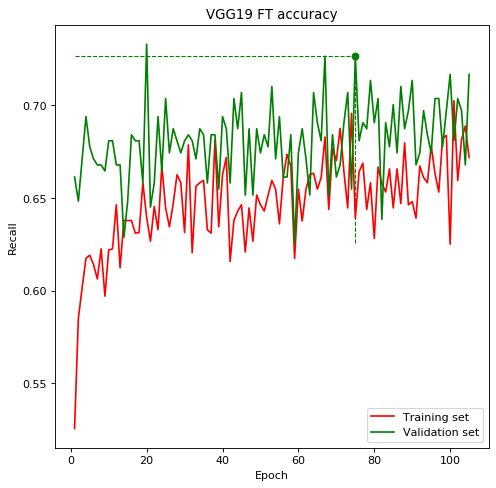

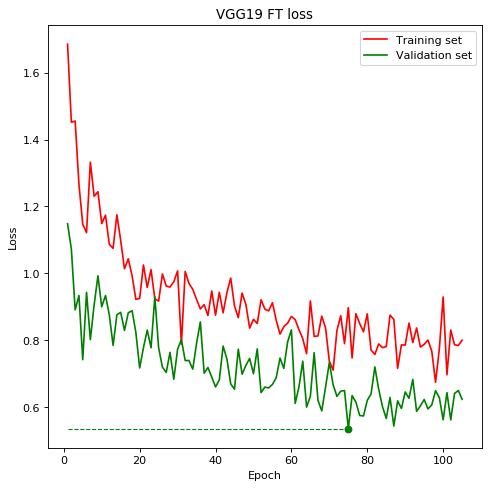

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

### Adamax

In [18]:
vgg19_calc_benign_or_malignant_best_Adamax = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_Adamax.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_Adamax.compile(optimizer=optimizers.Adamax(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [19]:
# Train
history_vgg19_calc_benign_or_malignant_best_Adamax = vgg19_calc_benign_or_malignant_best_Adamax.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 1.8263 - recall: 0.6217
Epoch 00001: val_loss improved from inf to 1.40607, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.7179 - recall: 0.6276 - val_loss: 1.4061 - val_recall: 0.5570
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1037 - recall: 0.6022
Epoch 00002: val_loss improved from 1.40607 to 1.11232, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adamax.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1148 - recall: 0.6122 - val_loss: 1.1123 - val_recall: 0.6580
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.0923 - recall: 0.6602
Epoch 00003: val_loss improved from 1.11232 to 0.67603, saving model to ../model/vgg19_calc_benign_or_malignant_best_Adamax.h5
5/5 [=========

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5938 - recall: 0.6641
Epoch 00028: val_loss did not improve from 0.51916
5/5 [==============================] - 10s 2s/step - loss: 0.5873 - recall: 0.6719 - val_loss: 0.5380 - val_recall: 0.7394
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5817 - recall: 0.6582
Epoch 00029: val_loss did not improve from 0.51916
5/5 [==============================] - 11s 2s/step - loss: 0.5734 - recall: 0.6609 - val_loss: 0.5777 - val_recall: 0.7231
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5932 - recall: 0.6914
Epoch 00030: val_loss did not improve from 0.51916
5/5 [==============================] - 10s 2s/step - loss: 0.5817 - recall: 0.7016 - val_loss: 0.5556 - val_recall: 0.7362
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5925 - recall: 0.6758
Epoch 00031: val_loss did not improve from 0.51916
5/5 [==============================] - 10s 2s/step - loss: 

In [20]:
models.save_model(vgg19_calc_benign_or_malignant_best_Adamax, '../model/vgg19_calc_benign_or_malignant_end_Adamax.h5')

In [21]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adamax.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adamax.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_Adamax.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_Adamax.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_Adamax.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_Adamax.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 57
Epoch [opt]: 27
Valid recall [end]: 0.6840
Valid recall [opt]: 0.7427
Test recall [end]:  0.7003
Test recall [opt]:  0.7181
Valid loss [end]: 0.5635
Valid loss [opt]: 0.5192
Test loss [end]:  0.5134
Test loss [opt]:  0.5372


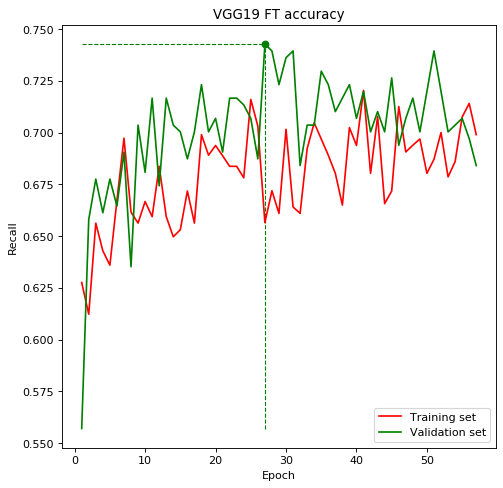

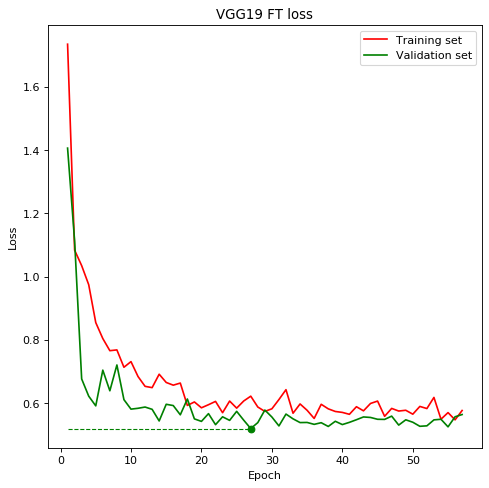

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

## Nadam

In [13]:
vgg19_calc_benign_or_malignant_best_Nadam = create_vgg19(dropout=0.5, fc_size=128, output = 2)

earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint('../model/vgg19_calc_benign_or_malignant_best_Nadam.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

vgg19_calc_benign_or_malignant_best_Nadam.compile(optimizer=optimizers.Nadam(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

In [14]:
# Train
history_vgg19_calc_benign_or_malignant_best_Nadam = vgg19_calc_benign_or_malignant_best_Nadam.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 2.0694 - recall: 0.5684
Epoch 00001: val_loss improved from inf to 1.01509, saving model to ../model/vgg19_calc_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 18s 4s/step - loss: 1.8223 - recall: 0.5884 - val_loss: 1.0151 - val_recall: 0.6059
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 1.2288 - recall: 0.6113
Epoch 00002: val_loss improved from 1.01509 to 0.88326, saving model to ../model/vgg19_calc_benign_or_malignant_best_Nadam.h5
5/5 [==============================] - 11s 2s/step - loss: 1.1357 - recall: 0.6141 - val_loss: 0.8833 - val_recall: 0.6189
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 1.1099 - recall: 0.6152
Epoch 00003: val_loss improved from 0.88326 to 0.68780, saving mode

In [15]:
models.save_model(vgg19_calc_benign_or_malignant_best_Nadam, '../model/vgg19_calc_benign_or_malignant_end_Nadam.h5')

In [16]:
tra_loss_fe = history_vgg19_calc_benign_or_malignant_best_Nadam.history['loss']
tra_acc_fe = history_vgg19_calc_benign_or_malignant_best_Nadam.history['recall']
val_loss_fe = history_vgg19_calc_benign_or_malignant_best_Nadam.history['val_loss']
val_acc_fe = history_vgg19_calc_benign_or_malignant_best_Nadam.history['val_recall']

epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

opt_vgg19_calc_benign_or_malignant = models.load_model('../model/vgg19_calc_benign_or_malignant_best_Nadam.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_best_Nadam.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant.evaluate(test_images, test_labels, verbose=False)

print("VGG19 benign or malignant\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 benign or malignant

Epoch [end]: 46
Epoch [opt]: 16
Valid recall [end]: 0.7231
Valid recall [opt]: 0.7557
Test recall [end]:  0.6973
Test recall [opt]:  0.7033
Valid loss [end]: 0.5283
Valid loss [opt]: 0.5077
Test loss [end]:  0.5281
Test loss [opt]:  0.5857


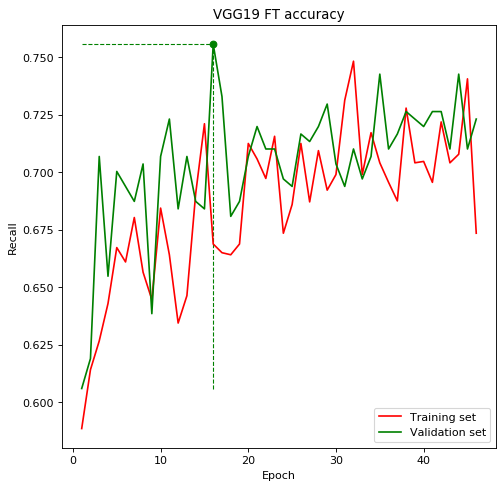

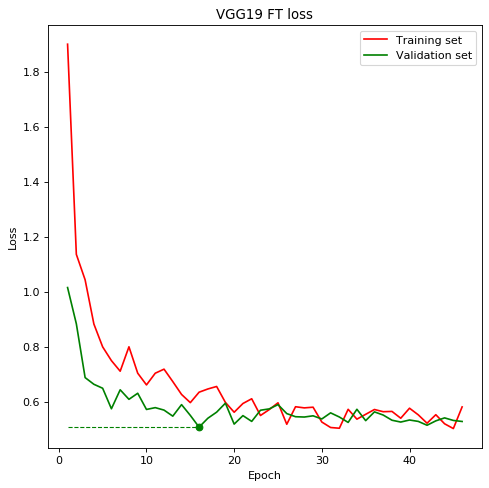

In [17]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

#### fine tuning

In [18]:
vgg19_calc_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg19_calc_benign_or_malignant_best_RMSprop.h5')

for layer in vgg19_calc_benign_or_malignant_fine_RMSprop.layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_benign_or_malignant_fine_RMSprop.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_benign_or_malignant_fine_RMSprop.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [19]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [20]:
history_fit = vgg19_calc_benign_or_malignant_fine_RMSprop.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.7142 - recall: 0.7261
Epoch 00001: val_loss improved from inf to 0.55656, saving model to ../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best.h5
5/5 [==============================] - 11s 2s/step - loss: 0.6583 - recall: 0.7279 - val_loss: 0.5566 - val_recall: 0.7394
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4773 - recall: 0.7480
Epoch 00002: val_loss did not improve from 0.55656
5/5 [==============================] - 11s 2s/step - loss: 0.4702 - recall: 0.7531 - val_loss: 0.6321 - val_recall: 0.7492
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4654 - recall: 0.7402
Epoch 00003: val_loss did not improve from 0.55656
5/5 [==============================] - 11s 2s/step - loss: 0.4721 - recall: 0.7422 - val_loss: 0.5730 - val_recall: 0.7166
Epoch 4/300
4/5 [====================

In [21]:
models.save_model(vgg19_calc_benign_or_malignant_fine_RMSprop, '../model/vgg19_calc_benign_or_malignant_fine_RMSprop_end.h5')

In [22]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_benign_or_malignant_fine_RMSprop = models.load_model('../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant_fine_RMSprop.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 46
Epoch [opt]: 16
Valid recall [end]: 0.7492
Valid recall [opt]: 0.7590
Test recall [end]:  0.7151
Test recall [opt]:  0.7151
Valid loss [end]: 0.5529
Valid loss [opt]: 0.4713
Test loss [end]:  0.6388
Test loss [opt]:  0.5218


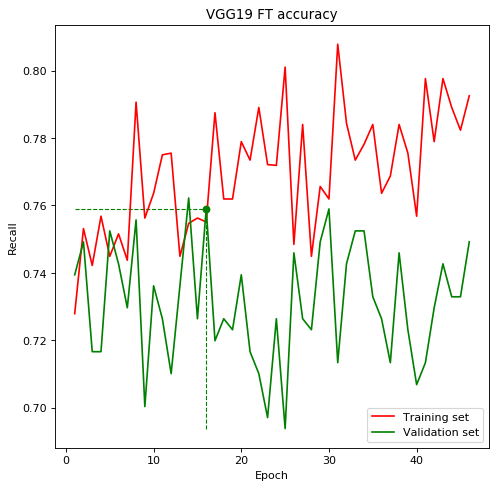

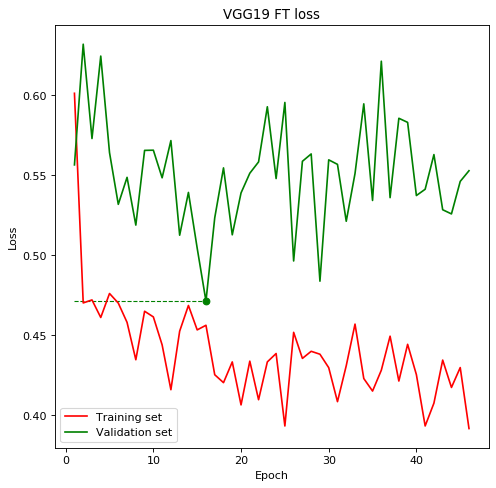

In [23]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [13]:
vgg19_calc_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best.h5')

for layer in vgg19_calc_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_benign_or_malignant_fine_RMSprop2.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_benign_or_malignant_fine_RMSprop2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [14]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best2.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [15]:
history_fit = vgg19_calc_benign_or_malignant_fine_RMSprop2.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 1.2837 - recall: 0.6426
Epoch 00001: val_loss improved from inf to 0.54698, saving model to ../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best2.h5
5/5 [==============================] - 16s 3s/step - loss: 1.1318 - recall: 0.6578 - val_loss: 0.5470 - val_recall: 0.7101
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5373 - recall: 0.7207
Epoch 00002: val_loss did not improve from 0.54698
5/5 [==============================] - 12s 2s/step - loss: 0.5224 - recall: 0.7296 - val_loss: 0.5540 - val_recall: 0.6971
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4664 - recall: 0.7478
Epoch 00003: val_loss improved from 0.54698 to 0.52117, saving model to ../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best2.h5


Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4456 - recall: 0.7539
Epoch 00029: val_loss did not improve from 0.49275
5/5 [==============================] - 10s 2s/step - loss: 0.4453 - recall: 0.7500 - val_loss: 0.5955 - val_recall: 0.7199
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4384 - recall: 0.7696
Epoch 00030: val_loss did not improve from 0.49275
5/5 [==============================] - 10s 2s/step - loss: 0.4477 - recall: 0.7670 - val_loss: 0.5387 - val_recall: 0.7329
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4303 - recall: 0.7969
Epoch 00031: val_loss did not improve from 0.49275
5/5 [==============================] - 10s 2s/step - loss: 0.4482 - recall: 0.7766 - val_loss: 0.5213 - val_recall: 0.7394
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4312 - recall: 0.7949
Epoch 00032: val_loss did not improve from 0.49275
5/5 [==============================] - 10s 2s/step - loss: 

In [16]:
models.save_model(vgg19_calc_benign_or_malignant_fine_RMSprop2, '../model/vgg19_calc_benign_or_malignant_fine_RMSprop_end2.h5')

In [17]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_benign_or_malignant_fine_RMSprop2 = models.load_model('../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best2.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant_fine_RMSprop2.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 55
Epoch [opt]: 25
Valid recall [end]: 0.7492
Valid recall [opt]: 0.7427
Test recall [end]:  0.7448
Test recall [opt]:  0.6795
Valid loss [end]: 0.5465
Valid loss [opt]: 0.4927
Test loss [end]:  0.5294
Test loss [opt]:  0.5888


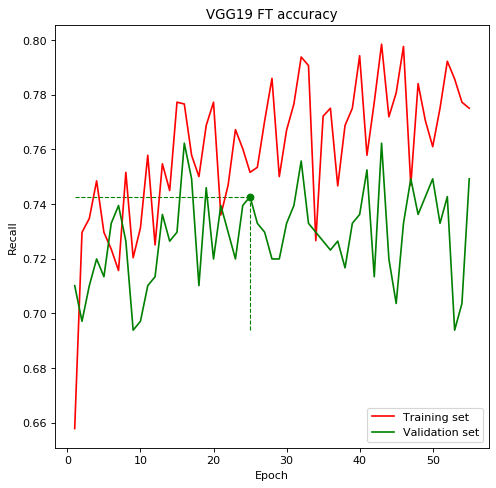

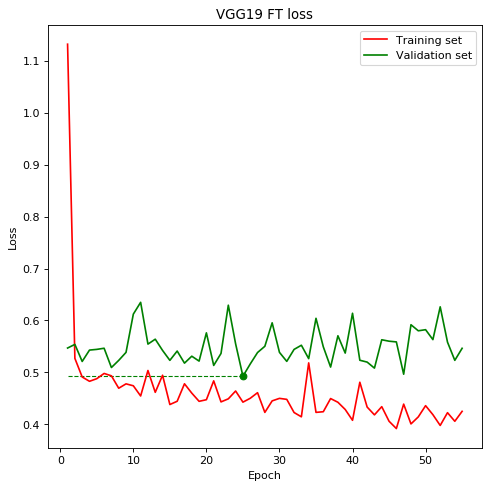

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [19]:
vgg19_calc_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best2.h5')

for layer in vgg19_calc_benign_or_malignant_fine_RMSprop2.layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg19_calc_benign_or_malignant_fine_RMSprop3.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                                            loss='categorical_crossentropy',
                                            metrics=[tf.keras.metrics.Recall(name='recall')])

vgg19_calc_benign_or_malignant_fine_RMSprop3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

checkpoint = ModelCheckpoint(
        '../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best3.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
     
    save_best_only=True, 
        save_freq='epoch')

In [21]:
history_fit = vgg19_calc_benign_or_malignant_fine_RMSprop3.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 1s - loss: 0.9460 - recall: 0.7188
Epoch 00001: val_loss improved from inf to 0.53182, saving model to ../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 11s 2s/step - loss: 0.8417 - recall: 0.7375 - val_loss: 0.5318 - val_recall: 0.7101
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5209 - recall: 0.7305
Epoch 00002: val_loss did not improve from 0.53182
5/5 [==============================] - 11s 2s/step - loss: 0.5094 - recall: 0.7344 - val_loss: 0.5496 - val_recall: 0.7329
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4169 - recall: 0.7812
Epoch 00003: val_loss improved from 0.53182 to 0.50850, saving model to ../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best3.h5
5/5 [==============================] - 11s 2s/step - loss: 0.4580 - recall: 

Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4270 - recall: 0.7891
Epoch 00030: val_loss did not improve from 0.46787
5/5 [==============================] - 10s 2s/step - loss: 0.4263 - recall: 0.7857 - val_loss: 0.6011 - val_recall: 0.7329
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4159 - recall: 0.7930
Epoch 00031: val_loss did not improve from 0.46787
5/5 [==============================] - 10s 2s/step - loss: 0.4292 - recall: 0.7781 - val_loss: 0.5763 - val_recall: 0.7296
Epoch 32/300
4/5 [=======================>......] - ETA: 1s - loss: 0.3859 - recall: 0.8043
Epoch 00032: val_loss did not improve from 0.46787
5/5 [==============================] - 10s 2s/step - loss: 0.3783 - recall: 0.8095 - val_loss: 0.7047 - val_recall: 0.6873
Epoch 33/300
4/5 [=======================>......] - ETA: 1s - loss: 0.4393 - recall: 0.7910
Epoch 00033: val_loss did not improve from 0.46787
5/5 [==============================] - 10s 2s/step - loss: 

In [22]:
models.save_model(vgg19_calc_benign_or_malignant_fine_RMSprop3, '../model/vgg19_calc_benign_or_malignant_fine_RMSprop_end3.h5')

In [23]:
# History of accuracy and loss
tra_loss_fe = history_fit.history['loss']
tra_acc_fe = history_fit.history['recall']
val_loss_fe = history_fit.history['val_loss']
val_acc_fe = history_fit.history['val_recall']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg19_calc_benign_or_malignant_fine_RMSprop3 = models.load_model('../model/vgg19_calc_benign_or_malignant_fine_RMSprop_best3.h5')
test_loss_fe, test_acc_fe = vgg19_calc_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg19_calc_benign_or_malignant_fine_RMSprop3.evaluate(test_images, test_labels, verbose=False)

print("VGG19 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid recall [end]: %.4f" % end_val_acc_fe)
print("Valid recall [opt]: %.4f" % opt_val_acc_fe)
print("Test recall [end]:  %.4f" % test_acc_fe)
print("Test recall [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG19 Fine Tuning

Epoch [end]: 44
Epoch [opt]: 14
Valid recall [end]: 0.7427
Valid recall [opt]: 0.7590
Test recall [end]:  0.6855
Test recall [opt]:  0.7181
Valid loss [end]: 0.5987
Valid loss [opt]: 0.4679
Test loss [end]:  0.7150
Test loss [opt]:  0.5255


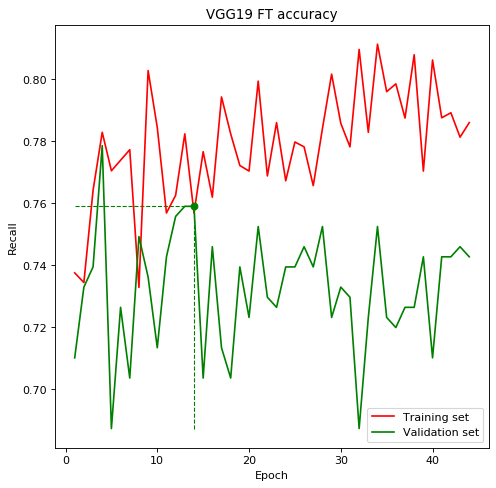

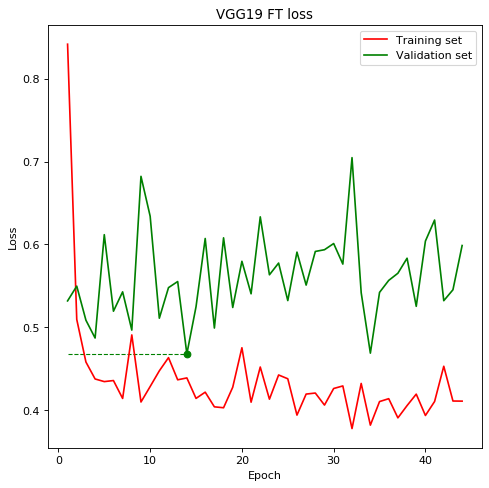

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT accuracy')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG19 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();